  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7238 sha256=8b90c6cfc38109363762f3a939889182eb912b80120f8477d9fb5848f41d84b6
  Stored in directory: c:\users\roman\appdata\local\pip\cache\wheels\6c\5a\a9\a28c87238ddcc61701224f538bedccc21c9e2b8bc6fa8fca0e
Successfully built panda


In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [207]:
grid=np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,14,10,10,0,0,0],
    [0,0,0,0,0,0,27,27,0,0,0,0,0,0,0,0,0,0,0,14,14,14,14,10,10,10,10],
    [0,0,0,0,0,27,27,27,27,0,0,0,0,0,0,0,0,0,0,14,14,14,14,10,10,10,10],
    [0,0,0,27,27,27,27,27,27,27,0,0,0,0,0,0,0,14,14,14,14,14,14,17,17,10,10],
    [27,27,27,27,27,27,27,27,27,27,27,0,0,0,0,0,0,14,14,14,14,14,14,14,17,17,17],
    [27,27,27,27,27,27,27,27,27,27,5,5,14,14,14,14,14,14,14,14,2,2,18,18,18,0,0],
    [27,27,27,27,27,27,27,27,27,20,20,5,5,5,5,14,14,24,24,2,2,2,2,18,0,0,0],
    [0,27,27,27,27,26,26,26,20,20,20,20,20,20,5,5,19,21,24,24,22,22,22,22,0,0,0],
    [0,26,26,26,26,26,26,26,20,20,20,20,20,5,5,5,21,21,11,11,11,1,1,15,0,0,0],
    [0,26,26,26,26,26,26,26,26,26,20,20,20,20,5,21,21,25,12,12,11,16,1,15,0,0,0],
    [0,0,0,26,26,26,26,26,26,26,26,20,20,20,25,25,25,25,12,12,12,16,23,23,0,0,0],
    [0,0,0,0,26,26,26,26,26,26,26,25,25,25,25,3,3,8,13,13,16,16,4,23,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,28,28,25,25,25,8,8,8,13,13,13,4,4,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,28,28,25,28,28,28,7,7,7,7,6,6,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,28,28,28,28,7,7,6,6,6,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,]
])
days=40
infected=pd.read_csv('data/time_series_covid19_confirmed_global.csv',usecols=range(4+days))
infected=infected[infected['Country/Region']=='China']
regions=pd.read_csv('data/regions.csv')
alpha,beta,gamma=0.21,1.4,1/5.1

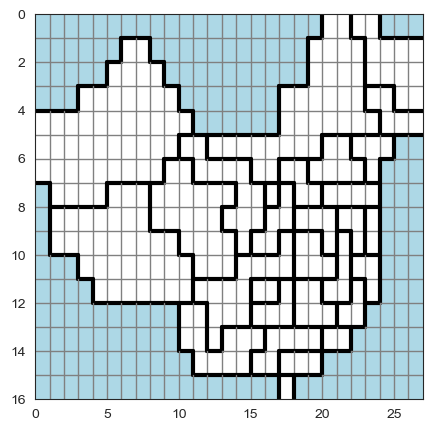

In [218]:
df = pd.DataFrame(grid)

cmap = sns.diverging_palette(0, 250, as_cmap=True)
color_map = cmap.from_list("", [(0, "lightblue"), (1, "white")], N=2)

f, ax = plt.subplots(figsize=(5, 5))
plt.pcolormesh(df, cmap=color_map, vmin=0,vmax=1)

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if j < df.shape[1] - 1 and df.iloc[i, j] != df.iloc[i, j + 1]:
            plt.plot([j + 1, j + 1], [i, i + 1], color="black", linewidth=3)
        elif j < df.shape[1] - 1:
            plt.plot([j + 1, j + 1], [i, i + 1], color="gray", linewidth=1)
        if i < df.shape[0] - 1 and df.iloc[i, j] != df.iloc[i + 1, j]:
            plt.plot([j, j + 1], [i + 1, i + 1], color="black", linewidth=3)
        elif i < df.shape[0] - 1:
            plt.plot([j, j + 1], [i + 1, i + 1], color="gray", linewidth=1)
            
plt.gca().invert_yaxis()
# Show the plot
plt.show()


In [154]:
ca_infected = np.zeros((days, grid.shape[0], grid.shape[1]))
region_population = regions[['ID', 'Cell Count']].set_index('ID').to_dict()['Cell Count']
for i in range(days):
    col_name=infected.columns[i+4]
    region_cases = infected[['Province/State', col_name]].set_index('Province/State').to_dict()[col_name]
    for j in range(grid.shape[0]):
        for k in range(grid.shape[1]):
            if grid[j, k] != 0:
                region_id = grid[j, k]
                cell_count = region_population[region_id]
                region_name = regions.loc[regions['ID'] == region_id, 'Region'].iloc[0]
                cases = 0
                if ',' in region_name:
                    region_list = region_name.split(',')
                    for sub_region in region_list:
                        sub_region = sub_region.strip()
                        cases += region_cases.get(sub_region, 0)
                else:
                    cases = region_cases.get(region_name, 0)
                ca_infected[i, j, k] = cases / cell_count

delta_i = np.diff(ca_infected, axis=0)

p = np.zeros((len(ca_infected) - 1, grid.shape[0], grid.shape[1], 6))
for i in range(1, len(ca_infected)):
    current_day = ca_infected[i - 1]
    north = np.zeros_like(current_day)
    north[1:] = current_day[:-1]
    south = np.zeros_like(current_day)
    south[:-1] = current_day[1:]
    east = np.zeros_like(current_day)
    east[:, 1:] = current_day[:, :-1]
    west = np.zeros_like(current_day)
    west[:, :-1] = current_day[:, 1:]
    current_cell = np.stack([np.ones_like(current_day), current_day, north, east, south, west], axis=-1)
    p[i - 1] = np.concatenate((current_cell[..., :1], current_cell[..., 1:] * (beta - gamma - alpha)), axis=-1)
